In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_json('..\\datasets\\headlines.json', lines=True)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [3]:
df = df[['headline', 'category']]
df

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS


In [4]:
df_headline_len = df['headline'].apply(lambda x: len(str(x).split(' ')))
df_headline_len

0         11
1         13
2         13
3          9
4         11
          ..
209522     8
209523    10
209524    17
209525     8
209526     9
Name: headline, Length: 209527, dtype: int64

                mean: 9.60
       harmonic mean: 8.29


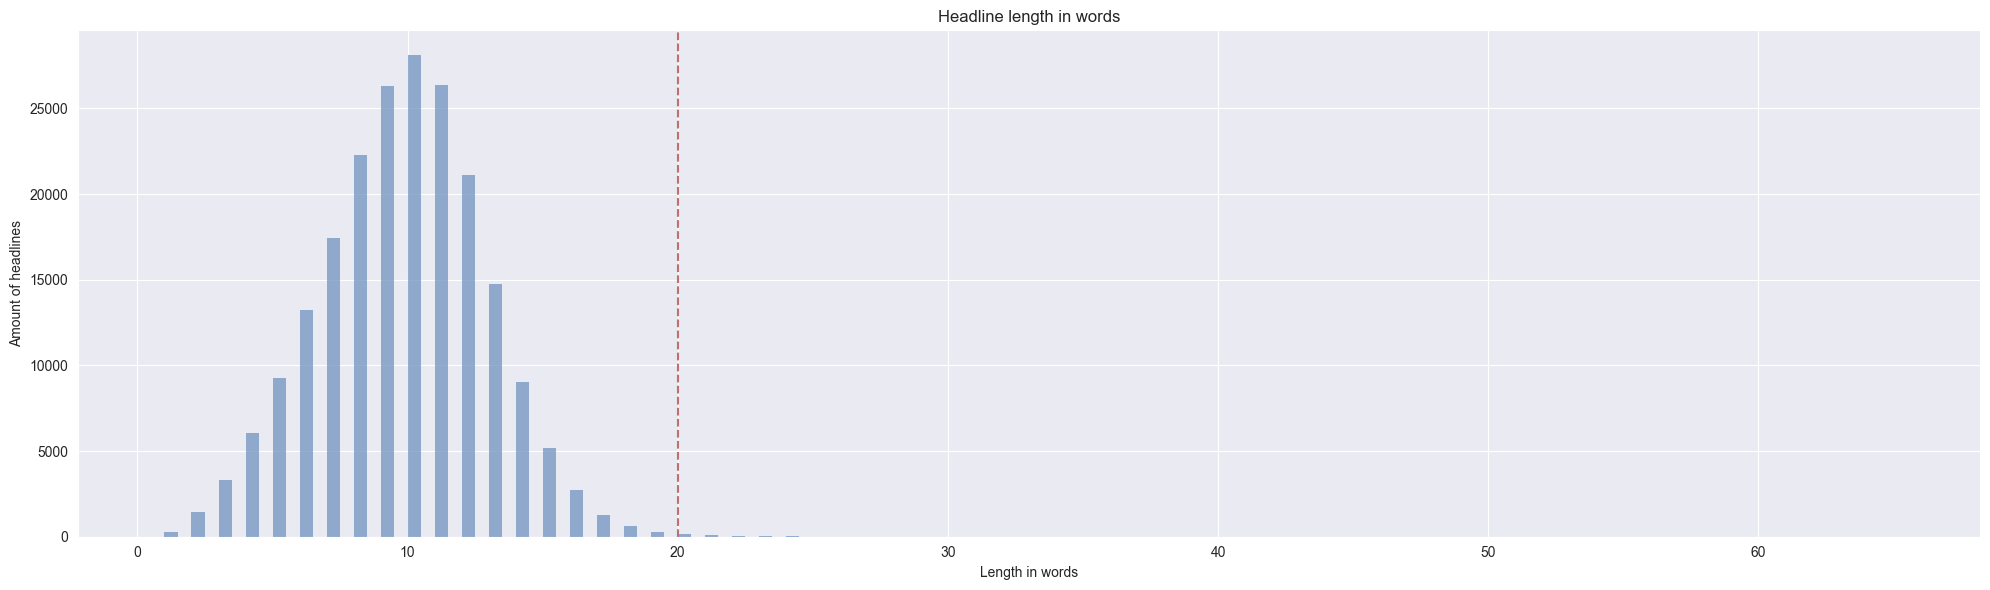

In [5]:
from matplotlib import pyplot as plt
from scipy.stats import hmean
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

max_headline_len = 20

harmonic_headline_mean = hmean(df_headline_len)
headline_mean = df_headline_len.mean()

print(
    f"{"mean":>20}: {headline_mean:.2f}",
    f"{"harmonic mean":>20}: {harmonic_headline_mean:.2f}", sep='\n'
)

fig, axes = plt.subplots(figsize=(20, 6))

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
sb.histplot(df_headline_len, ax=axes, binwidth=0.5, linewidth=0, color=mid_blue)
axes.axvline(x=max_headline_len, color=mid_red, linestyle='--', label='cutoff')

plt.tight_layout()

Beautiful gaussian curve.

In [6]:
cut_to = lambda length: df_headline_len <= length
shorter_than_20 = len(df[cut_to(20)])
longer_than_20 = len(df) - len(df[cut_to(20)])

print(
    "Amount of headlines",
    f"  shorter/equal to 20: {shorter_than_20:_}",
    f"       longer than 20: {longer_than_20:_}", sep='\n'
)

Amount of headlines
  shorter/equal to 20: 209_302
       longer than 20: 225


Since we're going to train our model on most average headline length. <br>
I don't see any point to use such small fraction of data. <br>
It can be very problematic for training our model. So we can safely remove it.

In [7]:
df = df[cut_to(max_headline_len)]

In [8]:
df_headline_len = df['headline'].apply(lambda x: len(str(x).split(' ')))
df_headline_len

0         11
1         13
2         13
3          9
4         11
          ..
209522     8
209523    10
209524    17
209525     8
209526     9
Name: headline, Length: 209302, dtype: int64

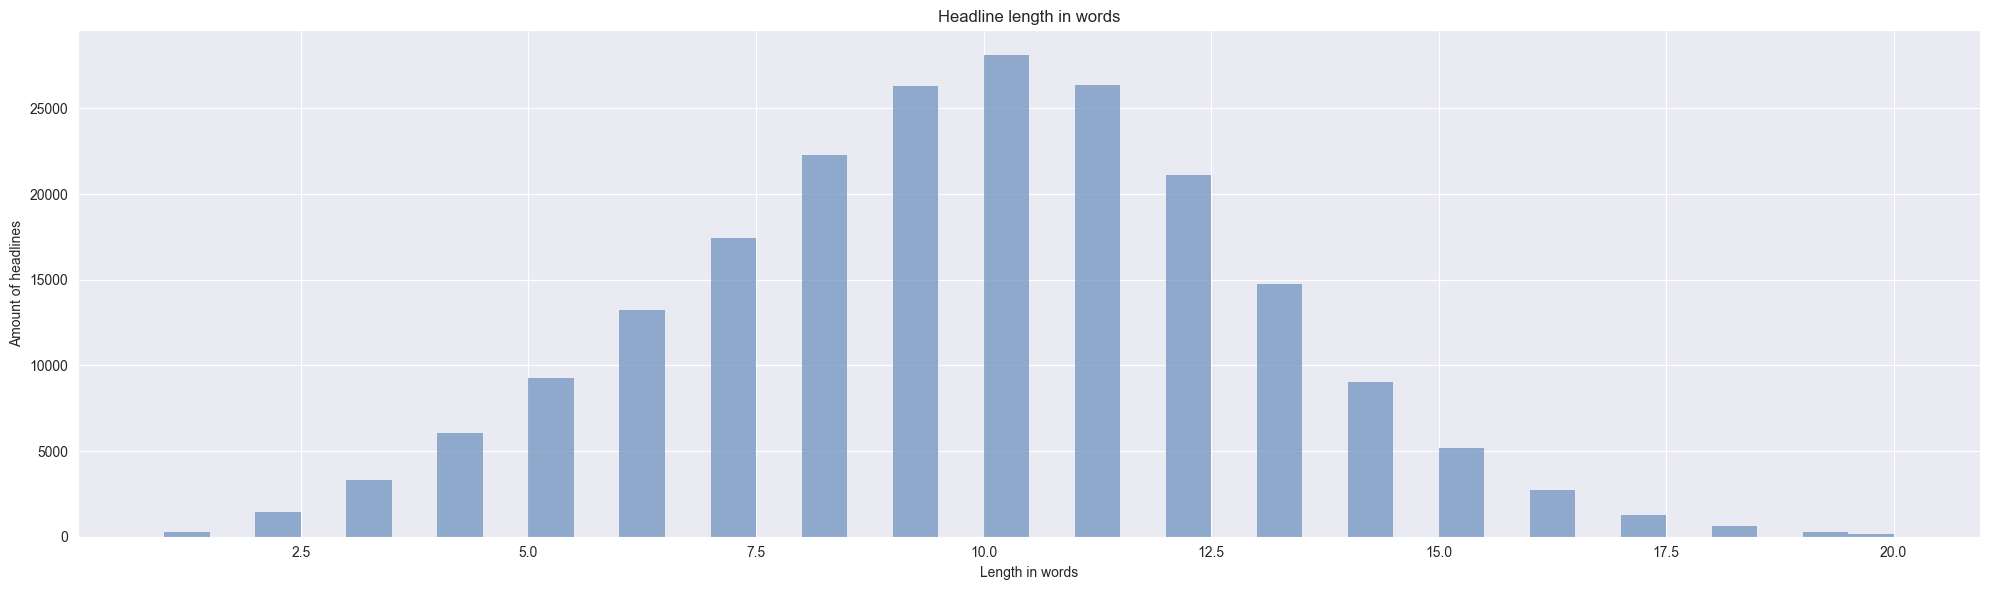

In [9]:
from matplotlib import pyplot as plt
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

max_headline_len = 20

fig, axes = plt.subplots(figsize=(20, 6))

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
sb.histplot(df_headline_len, ax=axes, binwidth=0.5, linewidth=0, color=mid_blue)

plt.tight_layout()

#### Tokenizing headlines
1) shuffle dataset so train and test contain exact amount of each category
2) apply tokenizing function

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
import re

def text_clean(text):
    result = text.lower()
    result = re.sub(r'[^a-zA-Z\s]', '', result)
    result = re.sub(r' +', ' ', result)
    return result

In [12]:
sample = '!@#this is "a   "sample! (T*eXt)...'
print(
    f"Before: {sample}",
    f"After: {text_clean(sample)}", sep='\n'
)

Before: !@#this is "a   "sample! (T*eXt)...
After: this is a sample text


In [13]:
df['headline'] = df['headline'].apply(lambda x: text_clean(str(x)))
df

,headline,category
0,the worlds most beautiful buildings photos,TRAVEL
1,jimmy kimmel convinces people neville longbott...,COMEDY
2,hair howto french braid video photos,STYLE & BEAUTY
3,there were more antimuslim hate crimes last ye...,POLITICS
4,hating refugees is pretty much as american as ...,POLITICS
...,...,...
209297,ellen slays halloween as the lost kardashian s...,ENTERTAINMENT
209298,selfcare and motherhood are not mutually exclu...,PARENTS
209299,the media needs to treat the benghazi committe...,POLITICS
209300,hunger games exposes myth of technological pro...,SCIENCE


In [14]:
from collections import Counter

tokenized_texts = [headline.split() for headline in df['headline']]
word_counts = Counter([word for headline in tokenized_texts
                            for word in headline])
word_counts.most_common(10)

[('the', 63324),
 ('to', 52552),
 ('of', 33273),
 ('a', 32394),
 ('in', 31900),
 ('for', 25437),
 ('and', 24363),
 ('is', 17895),
 ('on', 17393),
 ('with', 13781)]

In [15]:
word_to_idx = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}
word_to_idx['<PAD>'] = 0
idx_to_word = {i: word for word, i in word_to_idx.items()}

for i in range(10):
    print(idx_to_word[i])

<PAD>
the
to
of
a
in
for
and
is
on


In [16]:
import numpy as np

def vectorize_headline(headline):
    result = [word_to_idx[w] for w in headline.split()]
    result = np.pad(result, (0, max_headline_len - len(result)))
    return result

In [17]:
vectorize_headline(df['headline'][0])

array([   1,  328,   69,  458, 4394,   14,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [18]:
df['headline'] = df['headline'].apply(vectorize_headline)
df.head()

,headline,category
0,"[1, 328, 69, 458, 4394, 14, 0, 0, 0, 0, 0, 0, ...",TRAVEL
1,"[365, 1098, 17442, 60, 24239, 28677, 8, 5, 353...",COMEDY
2,"[332, 9105, 737, 9771, 26, 14, 0, 0, 0, 0, 0, ...",STYLE & BEAUTY
3,"[350, 186, 34, 3820, 532, 2319, 263, 114, 81, ...",POLITICS
4,"[6753, 838, 8, 777, 258, 29, 138, 29, 684, 240...",POLITICS


min: 1007
max: 35556


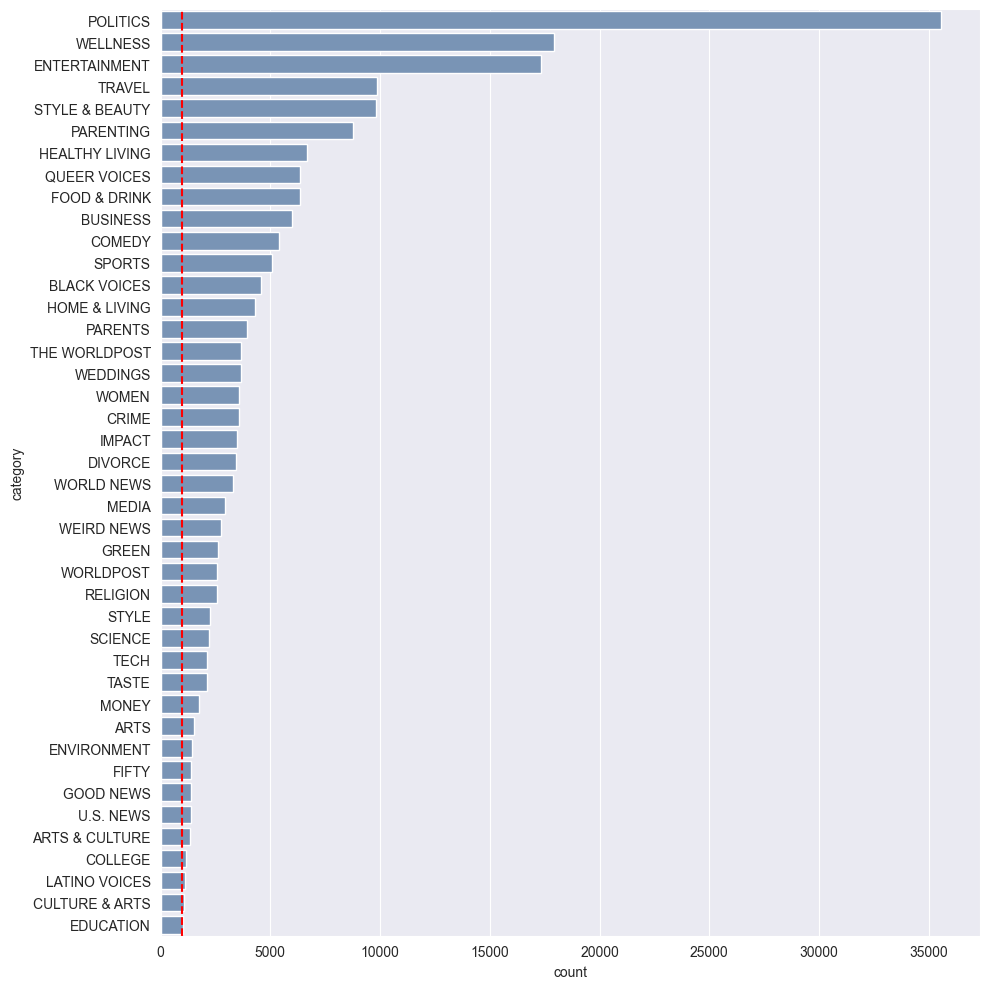

In [19]:
sorted_categories = df['category'].value_counts().index

fig, axes = plt.subplots(figsize=(10, 10))

print(
    f"min: {df['category'].value_counts().min()}",
    f"max: {df['category'].value_counts().max()}", sep='\n'
)

sb.countplot(df['category'], order=sorted_categories, color=mid_blue)
axes.axvline(x=1_000, color='red', linestyle='--')
plt.tight_layout()

#### Labeling categories

In [20]:
category_to_label = {
    cat: i for i, cat in enumerate(sorted_categories)
}

category_to_label

{'POLITICS': 0,
 'WELLNESS': 1,
 'ENTERTAINMENT': 2,
 'TRAVEL': 3,
 'STYLE & BEAUTY': 4,
 'PARENTING': 5,
 'HEALTHY LIVING': 6,
 'QUEER VOICES': 7,
 'FOOD & DRINK': 8,
 'BUSINESS': 9,
 'COMEDY': 10,
 'SPORTS': 11,
 'BLACK VOICES': 12,
 'HOME & LIVING': 13,
 'PARENTS': 14,
 'THE WORLDPOST': 15,
 'WEDDINGS': 16,
 'WOMEN': 17,
 'CRIME': 18,
 'IMPACT': 19,
 'DIVORCE': 20,
 'WORLD NEWS': 21,
 'MEDIA': 22,
 'WEIRD NEWS': 23,
 'GREEN': 24,
 'WORLDPOST': 25,
 'RELIGION': 26,
 'STYLE': 27,
 'SCIENCE': 28,
 'TECH': 29,
 'TASTE': 30,
 'MONEY': 31,
 'ARTS': 32,
 'ENVIRONMENT': 33,
 'FIFTY': 34,
 'GOOD NEWS': 35,
 'U.S. NEWS': 36,
 'ARTS & CULTURE': 37,
 'COLLEGE': 38,
 'LATINO VOICES': 39,
 'CULTURE & ARTS': 40,
 'EDUCATION': 41}

In [21]:
df['category'] = df['category'].apply(lambda cat: category_to_label[cat])
df.head()

,headline,category
0,"[1, 328, 69, 458, 4394, 14, 0, 0, 0, 0, 0, 0, ...",3
1,"[365, 1098, 17442, 60, 24239, 28677, 8, 5, 353...",10
2,"[332, 9105, 737, 9771, 26, 14, 0, 0, 0, 0, 0, ...",4
3,"[350, 186, 34, 3820, 532, 2319, 263, 114, 81, ...",0
4,"[6753, 838, 8, 777, 258, 29, 138, 29, 684, 240...",0


In [22]:
sequences = df['headline'].to_numpy()
labels = df['category'].to_numpy()

Checking if sequence is paired with label correctly

In [44]:
mismatches = df[df['headline'] != sequences]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])
    
mismatches = df[df['category'] != labels]
if not mismatches.empty:
    print(mismatches.iloc[0], sequences[mismatches.index[0]])

In [45]:
train_size = int(len(df) * 0.7)

train_split = sequences[:train_size], labels[:train_size]
test_split = sequences[train_size:], labels[train_size:]

In [46]:
len(test_split[0]) + len(train_split[0]) == len(df)

True

In [47]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def return_loader(dataset):

    sequences, labels = dataset
        
    x, y = [], []
    
    for sequence, label in zip(sequences, labels):
        x.append(sequence)
        y.append(label)
        
    tensor_dataset = TensorDataset(torch.tensor(x).long(),
                                   torch.tensor(y).long())
    
    return DataLoader(tensor_dataset, batch_size=16, drop_last=True)

In [48]:
train_loader  = return_loader(dataset=train_split)
test_loader = return_loader(dataset=test_split)

In [54]:
i = -1

for batch in test_loader:
    inputs, targets = batch
    print(len(batch[0]))
    print(inputs[i], targets[i])
    
    break

16
tensor([  350,     8,     4, 21548,     3, 57765,  6425,     7,    47,    89,
           28,    96,     0,     0,     0,     0,     0,     0,     0,     0]) tensor(8)


In [107]:
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        rnn_out, hidden = self.rnn(x)
        output = self.fc(hidden[0][-1])
        
        return output

In [108]:
torch.device('cuda') if torch.cuda.is_available() else 'cpu'

device(type='cuda')

In [109]:
from torch import optim

def train_model(model, data_loader, n_epochs=1, learning_rate=0.001):
    
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(data_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).long(),
                               targets.to(device).long())
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(data_loader)
        
        print(
            f"Epoch: {epoch+1} / {n_epochs}  |  loss: {avg_loss:.4f}"
        )

In [112]:
rnn_model = RNN(vocab_size=len(word_to_idx),
                embed_size=50,
                hidden_size=16,
                output_size=42)

In [113]:
train_model(
    model=rnn_model,
    data_loader=train_loader,
    n_epochs=20,
    learning_rate=0.001
)

Epoch: 1 / 20  |  loss: 2.9384
Epoch: 2 / 20  |  loss: 2.4268
Epoch: 3 / 20  |  loss: 2.0878
Epoch: 4 / 20  |  loss: 1.8799
Epoch: 5 / 20  |  loss: 1.7299
Epoch: 6 / 20  |  loss: 1.6099
Epoch: 7 / 20  |  loss: 1.5078
Epoch: 8 / 20  |  loss: 1.4183
Epoch: 9 / 20  |  loss: 1.3386
Epoch: 10 / 20  |  loss: 1.2669
Epoch: 11 / 20  |  loss: 1.2044
Epoch: 12 / 20  |  loss: 1.1470
Epoch: 13 / 20  |  loss: 1.0949
Epoch: 14 / 20  |  loss: 1.0472
Epoch: 15 / 20  |  loss: 1.0036
Epoch: 16 / 20  |  loss: 0.9647
Epoch: 17 / 20  |  loss: 0.9297
Epoch: 18 / 20  |  loss: 0.8947
Epoch: 19 / 20  |  loss: 0.8636
Epoch: 20 / 20  |  loss: 0.8342


In [114]:
def test_model(model, data_loader):

    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device).long(), targets.to(device).long()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

In [115]:
y_true, y_pred = test_model(model=rnn_model, data_loader=test_loader)

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     10734
           1       0.48      0.50      0.49      5440
           2       0.52      0.56      0.54      5238
           3       0.54      0.55      0.55      2966
           4       0.62      0.62      0.62      2886
           5       0.40      0.45      0.42      2647
           6       0.20      0.20      0.20      1946
           7       0.55      0.56      0.55      1871
           8       0.57      0.46      0.51      1899
           9       0.25      0.29      0.26      1794
          10       0.28      0.32      0.30      1586
          11       0.39      0.44      0.41      1526
          12       0.25      0.27      0.26      1386
          13       0.50      0.53      0.52      1267
          14       0.22      0.16      0.18      1169
          15       0.32      0.26      0.29      1072
          16       0.61      0.59      0.60      1072
          17       0.17    

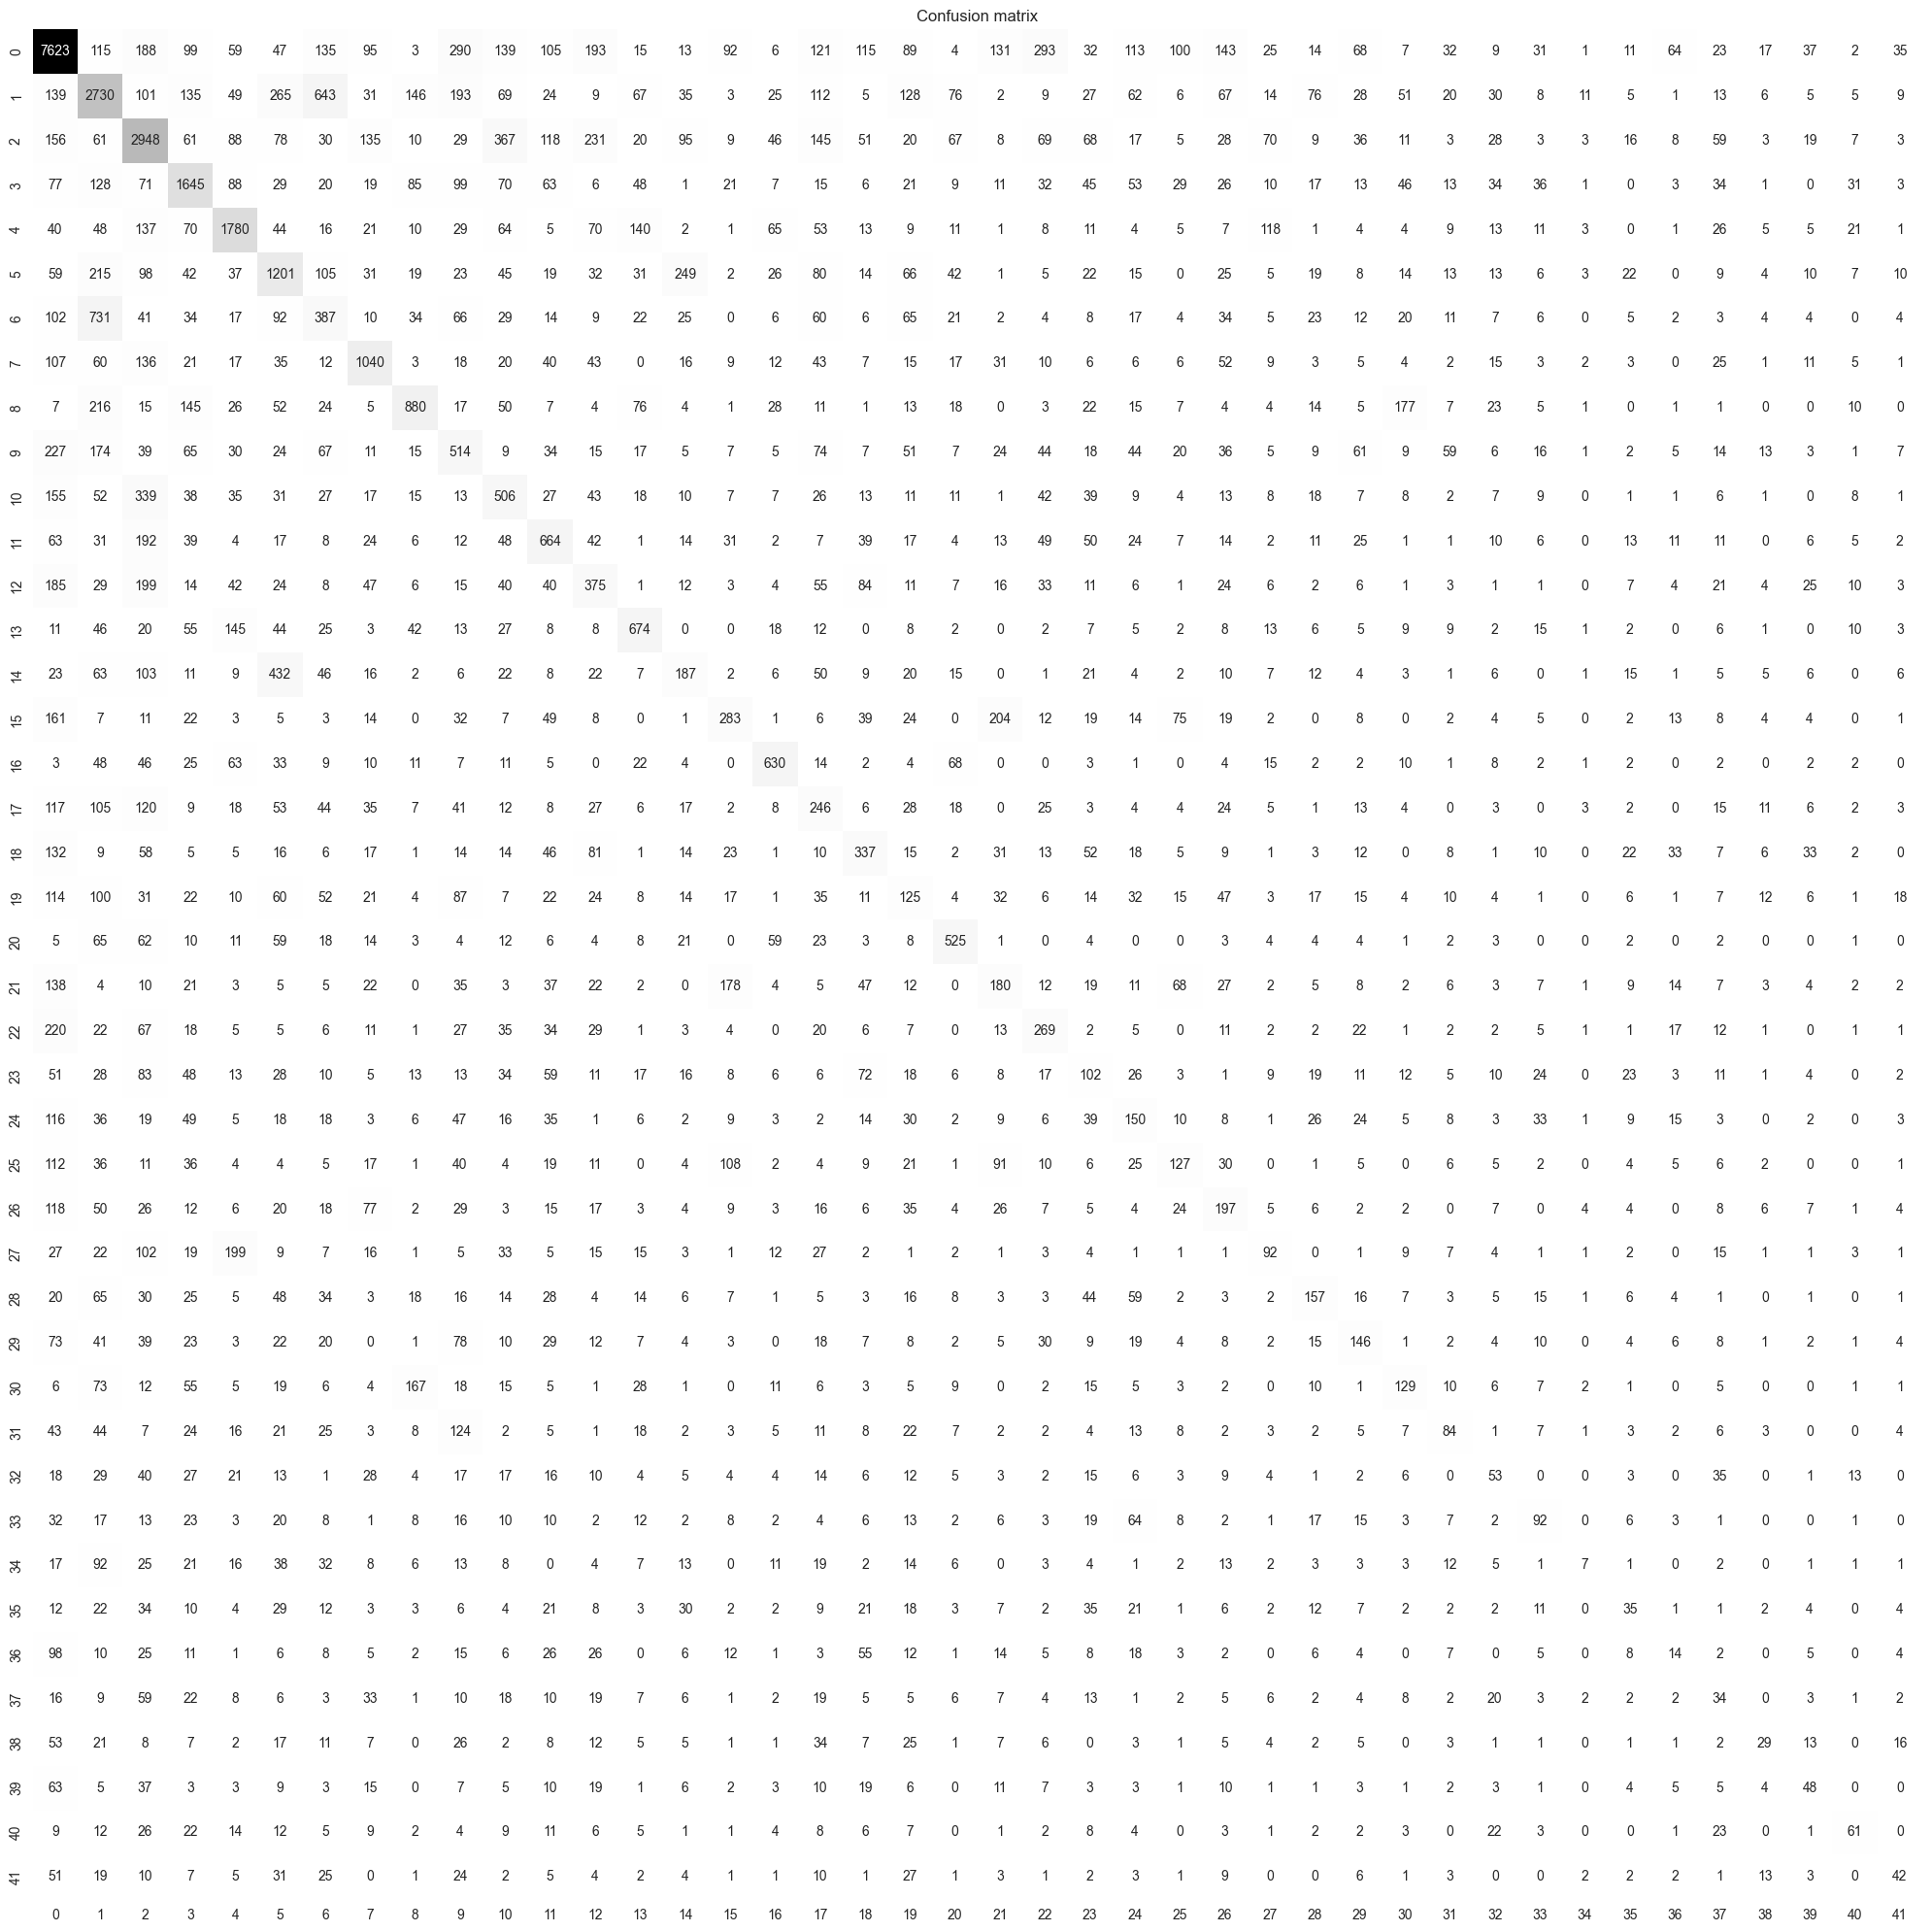

In [118]:
fig, ax = plt.subplots(figsize=(20, 20))

sb.heatmap(cm, cmap='Greys', fmt='d', annot=True, cbar=False)
plt.title('Confusion matrix')
plt.tight_layout()